<a href="https://colab.research.google.com/github/AI4Finance-Foundation/FinRL/blob/master/tutorials/1-Introduction/FinRL_PortfolioAllocation_NeurIPS_2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Reinforcement Learning for Stock Trading from Scratch: Portfolio Allocation

Tutorials to use OpenAI DRL to perform portfolio allocation in one Jupyter Notebook | Presented at NeurIPS 2020: Deep RL Workshop

* This blog is based on our paper: FinRL: A Deep Reinforcement Learning Library for Automated Stock Trading in Quantitative Finance, presented at NeurIPS 2020: Deep RL Workshop.
* Check out medium blog for detailed explanations: 
* Please report any issues to our Github: https://github.com/AI4Finance-Foundation/FinRL/issues
* **Pytorch Version** 



# Content

* [1. Problem Definition](#0)
* [2. Getting Started - Load Python packages](#1)
    * [2.1. Install Packages](#1.1)    
    * [2.2. Check Additional Packages](#1.2)
    * [2.3. Import Packages](#1.3)
    * [2.4. Create Folders](#1.4)
* [3. Download Data](#2)
* [4. Preprocess Data](#3)        
    * [4.1. Technical Indicators](#3.1)
    * [4.2. Perform Feature Engineering](#3.2)
* [5.Build Environment](#4)  
    * [5.1. Training & Trade Data Split](#4.1)
    * [5.2. User-defined Environment](#4.2)   
    * [5.3. Initialize Environment](#4.3)    
* [6.Implement DRL Algorithms](#5)  
* [7.Backtesting Performance](#6)  
    * [7.1. BackTestStats](#6.1)
    * [7.2. BackTestPlot](#6.2)   
    * [7.3. Baseline Stats](#6.3)   
    * [7.3. Compare to Stock Market Index](#6.4)             

<a id='0'></a>
# Part 1. Problem Definition

This problem is to design an automated trading solution for portfolio alloacation. We model the stock trading process as a Markov Decision Process (MDP). We then formulate our trading goal as a maximization problem.

The algorithm is trained using Deep Reinforcement Learning (DRL) algorithms and the components of the reinforcement learning environment are:


* Action: The action space describes the allowed actions that the agent interacts with the
environment. Normally, a ∈ A represents the weight of a stock in the porfolio: a ∈ (-1,1). Assume our stock pool includes N stocks, we can use a list [a<sub>1</sub>, a<sub>2</sub>, ... , a<sub>N</sub>] to determine the weight for each stock in the porfotlio, where a<sub>i</sub> ∈ (-1,1), a<sub>1</sub>+ a<sub>2</sub>+...+a<sub>N</sub>=1. For example, "The weight of AAPL in the portfolio is 10%." is [0.1 , ...].

* Reward function: r(s, a, s′) is the incentive mechanism for an agent to learn a better action. The change of the portfolio value when action a is taken at state s and arriving at new state s',  i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio
values at state s′ and s, respectively

* State: The state space describes the observations that the agent receives from the environment. Just as a human trader needs to analyze various information before executing a trade, so
our trading agent observes many different features to better learn in an interactive environment.

* Environment: Dow 30 consituents


The data of the single stock that we will be using for this case study is obtained from Yahoo Finance API. The data contains Open-High-Low-Close price and volume.


<a id='1'></a>
# Part 2. Getting Started- Load Python Packages

<a id='1.1'></a>
## 2.1. Install all the packages through FinRL library


In [4]:
## install finrl library
#%pip install git+https://github.com/AI4Finance-LLC/FinRL-Library.git


<a id='1.2'></a>
## 2.2. Check if the additional packages needed are present, if not install them. 
* Yahoo Finance API
* pandas
* numpy
* matplotlib
* stockstats
* OpenAI gym
* stable-baselines
* tensorflow
* pyfolio

<a id='1.3'></a>
## 2.3. Import Packages

In [5]:
import sys
import warnings
warnings.filterwarnings('ignore')
import talib as ta
from utils import process_future_data, dates_intersection, add_covariance, StockPortfolioEnv, create_features
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('Agg')
%matplotlib inline
import datetime

from finrl import config
from finrl import config_tickers
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_portfolio_allocation.env_portfolio import StockPortfolioEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline,convert_daily_return_to_pyfolio_ts
from finrl.meta.data_processor import DataProcessor
from finrl.meta.data_processors.processor_yahoofinance import YahooFinanceProcessor

sys.path.append("../FinRL-Library")

<a id='1.4'></a>
## 2.4. Create Folders

In [6]:
import os
if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

<a id='2'></a>
# Part 3. Download Data
Yahoo Finance is a website that provides stock data, financial news, financial reports, etc. All the data provided by Yahoo Finance is free.
* FinRL uses a class **YahooDownloader** to fetch data from Yahoo Finance API
* Call Limit: Using the Public API (without authentication), you are limited to 2,000 requests per hour per IP (or up to a total of 48,000 requests a day).


In [7]:
arrz = process_future_data('data/ARROZ.csv')
bg   = process_future_data('data/BOI_GORDO.csv')
cf   = process_future_data('data/CAFE.csv')
eth  = process_future_data('data/ETANOL.csv')
mil  = process_future_data('data/MILHO.csv')
mf   = process_future_data('data/MINERIO_FERRO.csv')
gold = process_future_data('data/OURO.csv')
petr = process_future_data('data/PETROLEO.csv')
soj  = process_future_data('data/SOJA.csv')
trg  = process_future_data('data/TRIGO.csv')

In [8]:
cmds_f =pd.concat([arrz,bg,cf,eth,mil,mf,gold,petr,soj,trg],axis=0) 

In [9]:
cmds_f['tic'].unique().tolist()

['ZR', 'LE', 'KC', 'FL', 'ZC', 'TR', 'GC', 'CB', 'ZS', 'ZW']

In [10]:
cmds_f_l = cmds_f["tic"].unique().tolist()
stocks_br  = ["PETR4.SA", "VALE3.SA", "ITUB4.SA", "MGLU3.SA", "BBAS3.SA", "BBDC4.SA","B3SA3.SA", "PETR3.SA", "RENT3.SA", "ELET3.SA" ]
stocks_usa = ["META", "AAPL", "AMZN", "F", "T", "BAC", "GOOGL", "MSFT", "INTC", "CMCSA"]
stocks_eur = ["iSP.MI", "ENEL.MI", "SAN.MC", "INGA.AS", "ENI.MI", "BBVA.MC", "IBE.MC", "CS.PA", "STLA.MI","DTE.DE"]
stocks_chn = ["601899.SS","600010.SS","600795.SS", "603993.SS", "600157.SS", "601288.SS", "600050.SS", "601398.SS", "600537.SS","600777.SS"]

In [11]:
ativos = list(set().union(stocks_br,stocks_usa,stocks_eur,stocks_chn))

In [12]:
len(ativos)

40

In [13]:
#print(config_tickers.DOW_30_TICKER)

In [14]:
dp = YahooFinanceProcessor()
df = dp.download_data(start_date = '2004-01-01',
                     end_date = '2022-11-07',
                     ticker_list = ativos, time_interval='1D')
ativos = list(set().union(stocks_br,stocks_usa,stocks_eur,stocks_chn,cmds_f_l))

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [15]:
df = pd.concat([df,cmds_f],axis=0)
df['date']= pd.to_datetime(df['date'])
df = df.sort_values(by='date')

# Part 4: Preprocess Data
Data preprocessing is a crucial step for training a high quality machine learning model. We need to check for missing data and do feature engineering in order to convert the data into a model-ready state.
* Add technical indicators. In practical trading, various information needs to be taken into account, for example the historical stock prices, current holding shares, technical indicators, etc. In this article, we demonstrate two trend-following technical indicators: MACD and RSI.
* Add turbulence index. Risk-aversion reflects whether an investor will choose to preserve the capital. It also influences one's trading strategy when facing different market volatility level. To control the risk in a worst-case scenario, such as financial crisis of 2007–2008, FinRL employs the financial turbulence index that measures extreme asset price fluctuation.

## Add covariance matrix as states

In [16]:
df = add_covariance(df)

## Adding Features

In [17]:
df = create_features(df)

In [18]:
dates_f3 = dates_intersection(df)
print(df.shape)
df=df[df['date'].isin(dates_f3)]
print(df.shape)

(222194, 21)
(77150, 21)


In [19]:
#df['tic'].value_counts()

In [20]:
df.shape

(77150, 21)

<a id='4'></a>
# Part 5. Design Environment
Considering the stochastic and interactive nature of the automated stock trading tasks, a financial task is modeled as a **Markov Decision Process (MDP)** problem. The training process involves observing stock price change, taking an action and reward's calculation to have the agent adjusting its strategy accordingly. By interacting with the environment, the trading agent will derive a trading strategy with the maximized rewards as time proceeds.

Our trading environments, based on OpenAI Gym framework, simulate live stock markets with real market data according to the principle of time-driven simulation.


In [21]:
print(df.date.head(1))
print(df.date.tail(1))

103124   2013-01-04
Name: date, dtype: datetime64[ns]
224906   2022-10-27
Name: date, dtype: datetime64[ns]


## Training data split: 2009-01-01 to 2020-07-01

In [22]:
train = data_split(df, '2013-01-04','2018-01-01')
trade = data_split(df,'2018-01-02', '2022-10-27')

In [23]:
train.head(1)

,date,open,high,low,close,adjcp,volume,tic,day,cov_list,...,RSI,slowk,slowd,WILLR,MACD,ROC,OBV,lag_20,lag_40,lag_60
0,2013-01-04,1.975,1.985714,1.928571,1.942857,1.899315,214400818.0,600010.SS,4,"[[0.0007838344569130898, 8.9325805536516e-05, ...",...,59.497655,53.365166,49.616944,-23.863621,0.03241,3.03031,6.918310e+10,0.182609,-0.003663,0.04817


In [24]:
train.tail(1)

,date,open,high,low,close,adjcp,volume,tic,day,cov_list,...,RSI,slowk,slowd,WILLR,MACD,ROC,OBV,lag_20,lag_40,lag_60
648,2017-11-21,2.762,2.798,2.752,2.768,1.722486,65018462.0,iSP.MI,1,"[[0.00026312101057223943, 3.700946382893613e-0...",...,26.27676,32.096751,36.486933,-82.432578,-0.031647,-2.877194,6.995558e+09,-0.046175,-0.069267,-0.015647


## Environment for Portfolio Allocation
##### Got from utils.py 

In [25]:
stock_dimension = len(train.tic.unique())
state_space = stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")


Stock Dimension: 50, State Space: 50


In [26]:
features =['RSI', 'slowk', 'slowd', 'WILLR', 'MACD','ROC', 'OBV', 'lag_20', 'lag_40', 'lag_60']

In [27]:
env_kwargs = {
    "hmax": 100, 
    "initial_amount": 1000000, 
    "transaction_cost_pct": 0.001, 
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": features, 
    "action_space": stock_dimension, 
    "reward_scaling": 1e-4
    
}

e_train_gym = StockPortfolioEnv(df = train, **env_kwargs)

In [28]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


# <a id='5'></a>
# Part 6: Implement DRL Algorithms
* The implementation of the DRL algorithms are based on **OpenAI Baselines** and **Stable Baselines**. Stable Baselines is a fork of OpenAI Baselines, with a major structural refactoring, and code cleanups.
* FinRL library includes fine-tuned standard DRL algorithms, such as DQN, DDPG,
Multi-Agent DDPG, PPO, SAC, A2C and TD3. We also allow users to
design their own DRL algorithms by adapting these DRL algorithms.

In [29]:
# initialize
agent = DRLAgent(env = env_train)

### Model 1: **A2C**


In [30]:
agent = DRLAgent(env = env_train)

A2C_PARAMS = {"n_steps": 5, "ent_coef": 0.005, "learning_rate": 0.0002}
model_a2c = agent.get_model(model_name="a2c",model_kwargs = A2C_PARAMS)

{'n_steps': 5, 'ent_coef': 0.005, 'learning_rate': 0.0002}
Using cpu device


In [31]:
#trained_a2c = agent.train_model(model=model_a2c, tb_log_name='a2c',total_timesteps=50000)

In [32]:
#trained_a2c.save('trained_models/trained_a2c.zip')
trained_a2c = model_a2c.load('trained_models/trained_a2c.zip')

### Model 2: **PPO**


In [33]:
agent = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.005,
    "learning_rate": 0.0001,
    "batch_size": 128,
}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)

{'n_steps': 2048, 'ent_coef': 0.005, 'learning_rate': 0.0001, 'batch_size': 128}
Using cpu device


In [34]:
#trained_ppo = agent.train_model(model=model_ppo, tb_log_name='ppo',total_timesteps=80000)

In [35]:
#trained_ppo.save('trained_models/trained_ppo.zip')
trained_ppo = model_ppo.load('trained_models/trained_ppo.zip')

### Model 3: **DDPG**


In [36]:
agent = DRLAgent(env = env_train)
DDPG_PARAMS = {"batch_size": 128, "buffer_size": 50000, "learning_rate": 0.001}


model_ddpg = agent.get_model("ddpg",model_kwargs = DDPG_PARAMS)

{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}
Using cpu device


In [37]:
#trained_ddpg = agent.train_model(model=model_ddpg, tb_log_name='ddpg',total_timesteps=50000)

In [38]:
#trained_ddpg.save('trained_models/trained_ddpg.zip')
trained_ddpg = model_ddpg.load('trained_models/trained_ddpg.zip')

### Model 4: **SAC**


In [39]:
agent = DRLAgent(env = env_train)
SAC_PARAMS = {
    "batch_size": 128,
    "buffer_size": 100000,
    "learning_rate": 0.0003,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
}

model_sac = agent.get_model("sac",model_kwargs = SAC_PARAMS)

{'batch_size': 128, 'buffer_size': 100000, 'learning_rate': 0.0003, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
Using cpu device


In [40]:
#trained_sac = agent.train_model(model=model_sac, tb_log_name='sac',total_timesteps=50000)

In [41]:
#trained_sac.save('trained_models/trained_sac.zip')
trained_sac = model_sac.load('trained_models/trained_sac.zip')

### Model 5: **TD3**


In [42]:
agent = DRLAgent(env = env_train)
TD3_PARAMS = {"batch_size": 100, 
              "buffer_size": 1000000, 
              "learning_rate": 0.001}

model_td3 = agent.get_model("td3",model_kwargs = TD3_PARAMS)

{'batch_size': 100, 'buffer_size': 1000000, 'learning_rate': 0.001}
Using cpu device


In [43]:
#trained_td3 = agent.train_model(model=model_td3, tb_log_name='td3',total_timesteps=30000)

In [44]:
#trained_td3.save('trained_models/trained_td3.zip')
trained_td3 = model_td3.load('trained_models/trained_td3.zip')

## Trading
Assume that we have $1,000,000 initial capital at 2019-01-01. We use the A2C model to trade Dow jones 30 stocks.

In [45]:
e_trade_gym = StockPortfolioEnv(df = trade, **env_kwargs)

In [46]:
#trained_sac
#trained_ddpg
#trained_ppo
#trained_a2c
#trained_td3

df_daily_return, df_actions = DRLAgent.DRL_prediction(model=trained_sac,
                        environment = e_trade_gym)

df_daily_return2, df_actions2 = DRLAgent.DRL_prediction(model=trained_ddpg,
                        environment = e_trade_gym)

df_daily_return3, df_actions3 = DRLAgent.DRL_prediction(model=trained_ppo,
                        environment = e_trade_gym)

df_daily_return4, df_actions4 = DRLAgent.DRL_prediction(model=trained_a2c,
                        environment = e_trade_gym)

df_daily_return5, df_actions5 = DRLAgent.DRL_prediction(model=trained_td3,
                        environment = e_trade_gym)

begin_total_asset:1000000
end_total_asset:1443718.8171224294
Sharpe:  0.6733560759351641
hit end!
begin_total_asset:1000000
end_total_asset:1398059.0099962521
Sharpe:  0.619052384626599
hit end!
begin_total_asset:1000000
end_total_asset:1432801.4489046747
Sharpe:  0.656067876922911
hit end!
begin_total_asset:1000000
end_total_asset:1436641.7311023918
Sharpe:  0.6741221387915829
hit end!
begin_total_asset:1000000
end_total_asset:1418251.140970006
Sharpe:  0.6303185722129029
hit end!


In [47]:
df_daily_return.to_csv('results/df_daily_return_sac.csv')
df_daily_return2.to_csv('results/df_daily_return_ddpg.csv')
df_daily_return3.to_csv('results/df_daily_return_ppo.csv')
df_daily_return4.to_csv('results/df_daily_return_a2c.csv')
df_daily_return5.to_csv('results/df_daily_return_td3.csv')

In [48]:
df_actions.to_csv( 'results/df_actions_sac.csv')
df_actions2.to_csv('results/df_actions_ddpg.csv')
df_actions3.to_csv('results/df_actions_ppo.csv')
df_actions4.to_csv('results/df_actions_a2c.csv')
df_actions5.to_csv('results/df_actions_td3.csv')

<a id='6'></a>
# Part 7: Backtest Our Strategy
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

<a id='6.1'></a>
## 7.1 BackTestStats
pass in df_account_value, this information is stored in env class


In [49]:
from pyfolio import timeseries
DRL_strat = convert_daily_return_to_pyfolio_ts(df_daily_return)
perf_func = timeseries.perf_stats 
perf_stats_all = perf_func( returns=DRL_strat, 
                              factor_returns=DRL_strat, 
                                positions=None, transactions=None, turnover_denom="AGB")

In [50]:
import pyfolio as pf

In [51]:
pf.create_full_tear_sheet(DRL_strat)

Start date,2018-05-10
End date,2022-10-26
Total months,42
,Backtest
Annual return,10.919%
Cumulative returns,44.372%
Annual volatility,17.748%
Sharpe ratio,0.67
Calmar ratio,0.36
Stability,0.80
Max drawdown,-30.579%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,30.58,2020-01-02,2020-03-23,2020-11-09,223
1,12.96,2022-03-29,2022-07-14,NaT,NaN
2,11.32,2018-05-10,2018-06-27,2019-02-15,202
3,7.13,2019-07-12,2019-08-26,2019-11-01,81
4,6.49,2019-04-23,2019-05-13,2019-06-21,44


In [52]:
##baseline stats
#print("==============Get Baseline Stats===========")
#baseline_df = get_baseline(
#        ticker="^DJI", 
#        start = df_daily_return5.loc[0,'date'],
#        end = df_daily_return5.loc[len(df_daily_return5)-1,'date'])
#
#stats = backtest_stats(baseline_df, value_col_name = 'close')

In [53]:
df_comp = trade[['date','close','tic']]
df_comp.set_index('date',inplace=True)
res = df_comp.pivot(columns='tic', values='close')


# Asset weights
weight = res.shape[1]
wts = np.full(shape=weight, fill_value=1/weight).tolist()
ret_data = res.pct_change()

weighted_returns = (1/weight * ret_data)
weighted_returns.index= pd.to_datetime(weighted_returns.index)
weighted_returns

tic,600010.SS,600050.SS,600157.SS,600537.SS,600777.SS,600795.SS,601288.SS,601398.SS,601899.SS,603993.SS,...,SAN.MC,STLA.MI,T,TR,VALE3.SA,ZC,ZR,ZS,ZW,iSP.MI
date,,,,,,,,,,,,,,,,,,,,,
2018-05-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-05-11,0.000000,-0.000448,-0.000502,-0.000197,-0.000971,-0.000069,0.000103,0.000233,0.000098,0.001087,...,0.000117,0.000260,0.000257,0.000389,0.000479,-0.000274,0.000208,-0.000353,-0.000306,0.000096
2018-05-14,-0.000099,0.000246,-0.000515,-0.000100,0.000000,-0.000069,0.000153,0.000000,-0.000097,0.000344,...,-0.000043,-0.000025,-0.000062,0.000305,0.000623,0.000000,-0.000237,0.000289,-0.000301,0.000025
2018-05-15,0.000100,0.000522,0.000088,0.000050,-0.000544,0.000139,-0.000102,0.000066,-0.000195,0.000097,...,-0.000142,-0.000107,-0.000062,-0.000248,0.000140,0.000290,-0.000032,0.000020,0.000092,0.000178
2018-05-16,-0.000099,-0.000339,0.000088,-0.000150,-0.000559,0.000138,-0.000357,-0.000296,-0.000493,-0.000360,...,-0.000505,-0.000127,0.000131,0.000006,0.000457,-0.000149,0.000104,-0.000373,0.000030,-0.000491
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-20,0.000000,0.000178,0.000000,-0.001182,0.000391,-0.000432,0.000070,0.000046,-0.000177,-0.000140,...,0.000258,0.000318,0.001544,-0.000021,0.000256,0.000170,-0.000030,0.000401,0.000190,0.000418
2022-10-21,-0.000108,0.000176,-0.000121,-0.000214,-0.000230,0.000971,0.000070,0.000000,0.000204,-0.000047,...,-0.000079,-0.000152,0.000430,0.000021,0.000586,0.000007,-0.000155,0.000064,0.000035,-0.000015
2022-10-24,-0.000432,-0.000465,-0.000122,-0.000805,-0.000310,-0.000547,-0.000070,0.000046,0.000025,-0.000516,...,0.000497,0.000612,0.000480,-0.000923,-0.000594,-0.000080,-0.000126,-0.000331,-0.000282,0.000309


In [54]:
ptf_return= (weighted_returns.sum(axis=1,skipna=False))
ptf_return.name= 'Portfolio Returns'
ptf_return.index=DRL_strat.index

<a id='6.2'></a>
## 7.2 BackTestPlot

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1125, 8)


Start date,2018-05-10
End date,2022-10-26
Total months,42
,Backtest
Annual return,10.919%
Cumulative returns,44.372%
Annual volatility,17.748%
Sharpe ratio,0.67
Calmar ratio,0.36
Stability,0.80
Max drawdown,-30.579%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,30.58,2020-01-02,2020-03-23,2020-11-09,223
1,12.96,2022-03-29,2022-07-14,NaT,NaN
2,11.32,2018-05-10,2018-06-27,2019-02-15,202
3,7.13,2019-07-12,2019-08-26,2019-11-01,81
4,6.49,2019-04-23,2019-05-13,2019-06-21,44


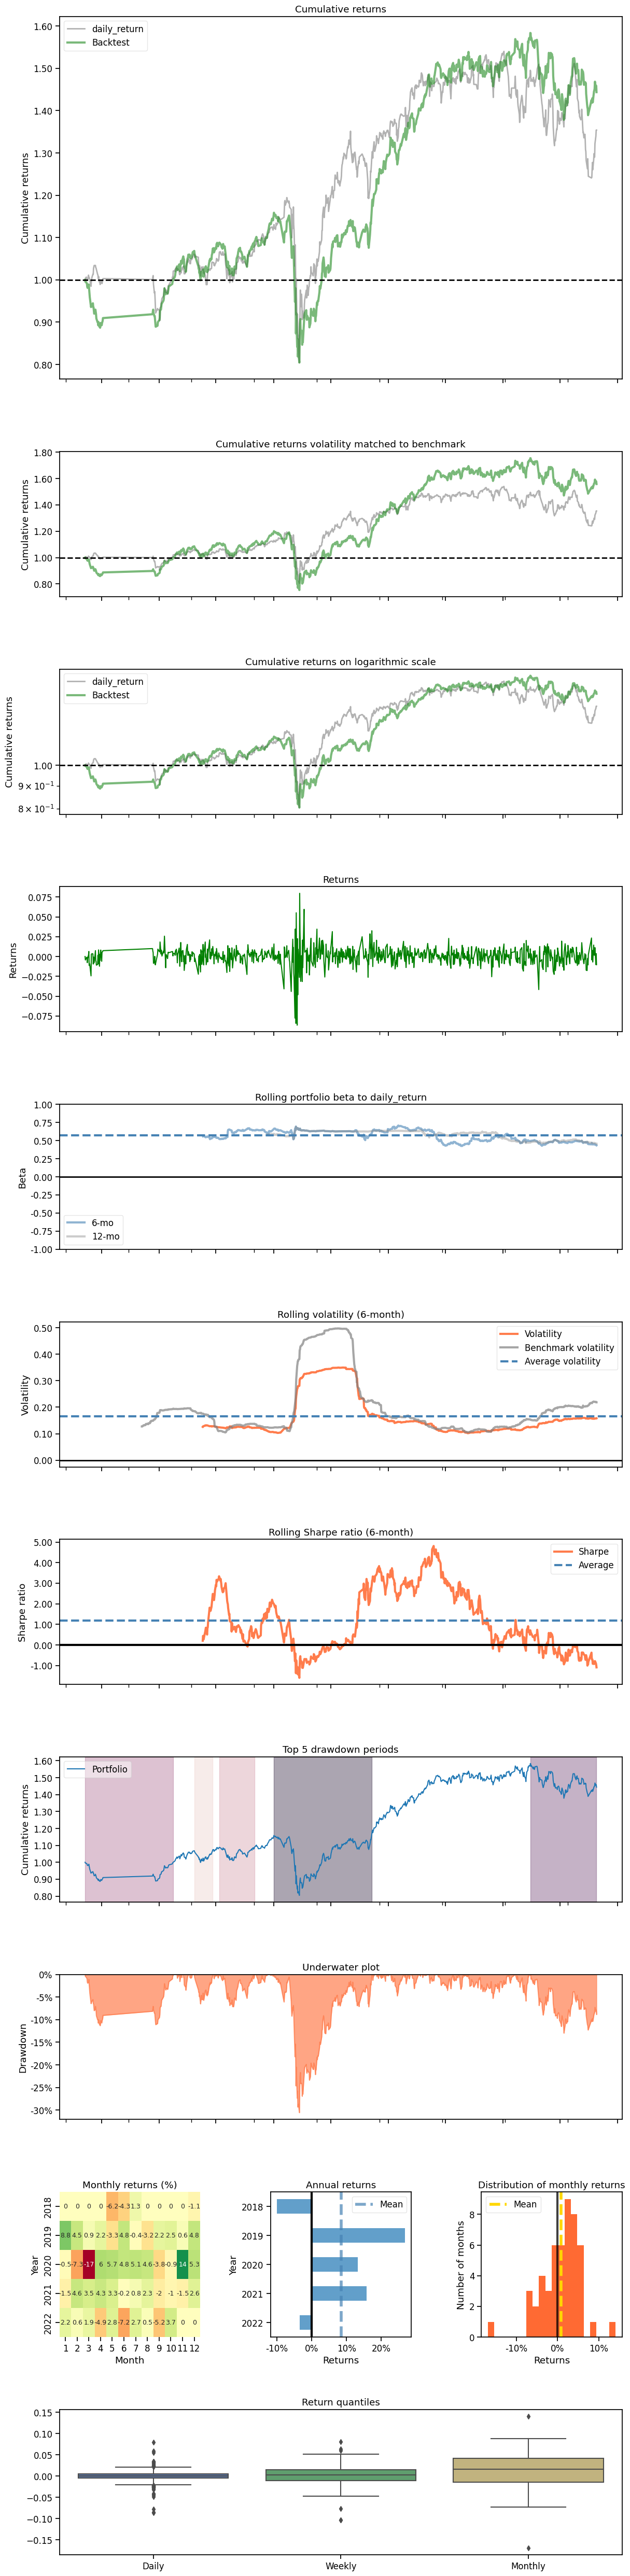

In [55]:
import pyfolio
%matplotlib inline

baseline_df = get_baseline(
        ticker='^DJI', start=df_daily_return5.loc[0,'date'], end='2022-10-27'
    )

baseline_returns = get_daily_return(baseline_df, value_col_name="close")

with pyfolio.plotting.plotting_context(font_scale=1.1):
        pyfolio.create_full_tear_sheet(returns = DRL_strat,
                                       benchmark_rets=baseline_returns, set_context=False)

Start date,2018-05-10
End date,2022-10-26
Total months,42
,Backtest
Annual return,10.919%
Cumulative returns,44.372%
Annual volatility,17.748%
Sharpe ratio,0.67
Calmar ratio,0.36
Stability,0.80
Max drawdown,-30.579%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,30.58,2020-01-02,2020-03-23,2020-11-09,223
1,12.96,2022-03-29,2022-07-14,NaT,NaN
2,11.32,2018-05-10,2018-06-27,2019-02-15,202
3,7.13,2019-07-12,2019-08-26,2019-11-01,81
4,6.49,2019-04-23,2019-05-13,2019-06-21,44


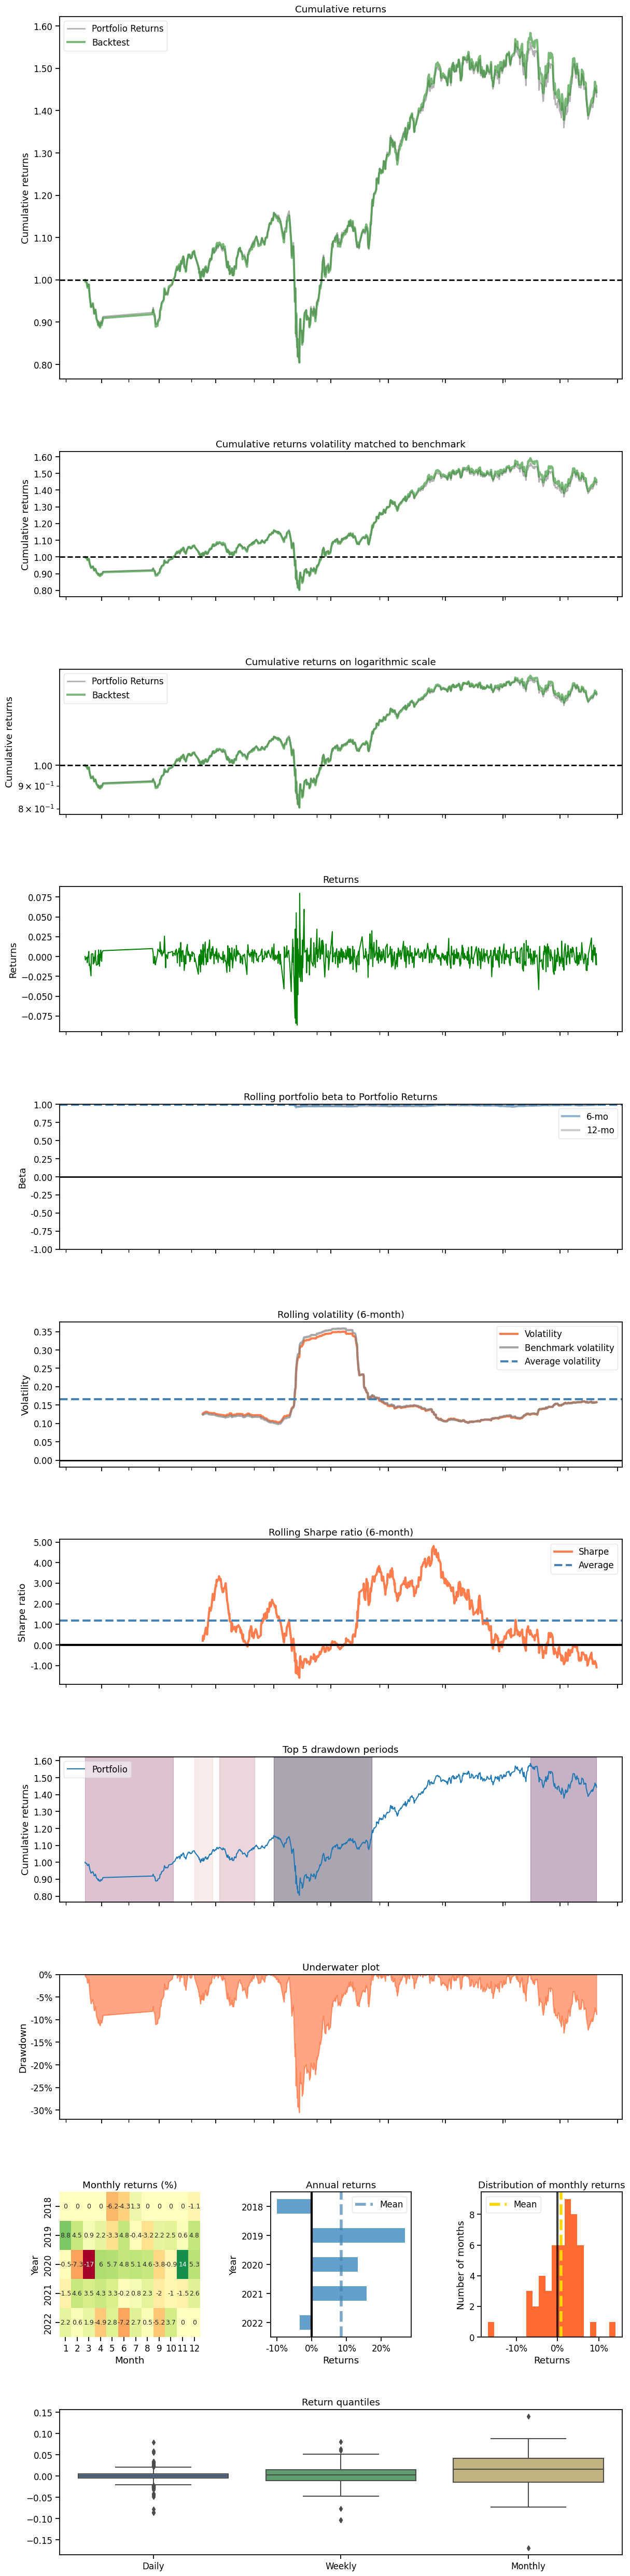

In [56]:
with pyfolio.plotting.plotting_context(font_scale=1.1):
        pyfolio.create_full_tear_sheet(returns = DRL_strat,
                                       benchmark_rets=ptf_return, set_context=False)

## Min-Variance Portfolio Allocation

In [57]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models

In [58]:
#calculate_portfolio_minimum_variance
unique_tic = trade.tic.unique()
unique_trade_date = trade.date.unique()

portfolio = pd.DataFrame(index = range(1), columns = unique_trade_date)
initial_capital = 1000000
portfolio.loc[0,unique_trade_date[0]] = initial_capital

for i in range(len( unique_trade_date)-1):
    df_temp = trade[trade.date==unique_trade_date[i]].reset_index(drop=True)
    df_temp_next = trade[trade.date==unique_trade_date[i+1]].reset_index(drop=True)
    #Sigma = risk_models.sample_cov(df_temp.return_list[0])
    #calculate covariance matrix
    Sigma = df_temp.return_list[0].cov()
    #portfolio allocation
    ef_min_var = EfficientFrontier(None, Sigma,weight_bounds=(0, 0.1))
    #minimum variance
    raw_weights_min_var = ef_min_var.min_volatility()
    #get weights
    cleaned_weights_min_var = ef_min_var.clean_weights()
    
    #current capital
    cap = portfolio.iloc[0, i]
    #current cash invested for each stock
    current_cash = [element * cap for element in list(cleaned_weights_min_var.values())]
    # current held shares
    current_shares = list(np.array(current_cash)
                                      / np.array(df_temp.close))
    # next time period price
    next_price = np.array(df_temp_next.close)
    ##next_price * current share to calculate next total account value 
    portfolio.iloc[0, i+1] = np.dot(current_shares, next_price)
    
portfolio=portfolio.T
portfolio.columns = ['account_value']

In [59]:
min_var_cumpod =(portfolio.account_value.pct_change()+1).cumprod()-1

In [60]:
#min_var_distribution = pd.DataFrame({'Ativo': stock_list, 'Peso': weight_list})
#min_var_distribution.set_index('Ativo',inplace= True)
#min_var_distribution[min_var_distribution>0].dropna().plot(y = 'Peso', kind= 'pie', figsize =(20,20))

In [61]:
#min_var_ptf= (min_var_returns.sum(axis=1,skipna=False))
#min_var_ptf.name= 'Min Var PTF Returns'
#min_var_ptf.index=DRL_strat.index

In [62]:
#with pyfolio.plotting.plotting_context(font_scale=1.1):pyfolio.create_full_tear_sheet(returns = DRL_strat,benchmark_rets=min_var_ptf, set_context=False)

In [63]:
#with pyfolio.plotting.plotting_context(font_scale=1.1):pyfolio.create_full_tear_sheet(returns = min_var_ptf,benchmark_rets=DRL_strat, set_context=False)

In [64]:
#trained_sac
#trained_ddpg
#trained_ppo
#trained_a2c
sac_cumpod = (df_daily_return.daily_return+1).cumprod()-1
ddpg_cumpod  = (df_daily_return2.daily_return+1).cumprod()-1
ppo_cumpod  = (df_daily_return3.daily_return+1).cumprod()-1
a2c_cumpod   = (df_daily_return4.daily_return+1).cumprod()-1
td3_cumpod = (df_daily_return5.daily_return+1).cumprod()-1


In [65]:
#min_var_cumpod =(portfolio.account_value.pct_change().fillna(0)+1).cumprod()-1
#min_var_cumpod =(min_var_ptf.fillna(0)+1).cumprod()-1

In [66]:
dji_cumpod =(baseline_returns.fillna(0)+1).cumprod()-1

In [67]:
ptf_cumpod =(ptf_return.fillna(0)+1).cumprod()-1

## Plotly: DRL, Min-Variance, DJIA

In [68]:
from datetime import datetime as dt

import matplotlib.pyplot as plt
import plotly
import plotly.graph_objs as go

In [69]:
time_ind = pd.Series(df_daily_return.date)

In [70]:
#trained_sac
#trained_ddpg
#trained_ppo
#trained_a2c


trace0_portfolio = go.Scatter(x = time_ind, y = a2c_cumpod, mode = 'lines', name = 'A2C')
trace1_portfolio = go.Scatter(x = time_ind, y = dji_cumpod, mode = 'lines', name = 'DJIA')
trace2_portfolio = go.Scatter(x = time_ind, y = min_var_cumpod, mode = 'lines', name = 'Min-Variance')
trace3_portfolio = go.Scatter(x = time_ind, y = ptf_cumpod, mode = 'lines', name = 'Portfolio Buy & Hold')
trace4_portfolio = go.Scatter(x = time_ind, y = ddpg_cumpod, mode = 'lines', name = 'DDPG')
trace5_portfolio = go.Scatter(x = time_ind, y = sac_cumpod, mode = 'lines', name = 'SAC')
trace6_portfolio = go.Scatter(x = time_ind, y = ppo_cumpod, mode = 'lines', name = 'PPO')
trace7_portfolio = go.Scatter(x = time_ind, y = td3_cumpod, mode = 'lines', name = 'TD3')

In [74]:
fig = go.Figure()
fig.add_trace(trace0_portfolio)
fig.add_trace(trace1_portfolio)
fig.add_trace(trace2_portfolio)
fig.add_trace(trace3_portfolio)
fig.add_trace(trace4_portfolio)
fig.add_trace(trace5_portfolio)
fig.add_trace(trace6_portfolio)
fig.add_trace(trace7_portfolio)




fig.update_layout(
    legend=dict(
        x=0,
        y=1,
        traceorder="normal",
        font=dict(
            family="arial",
            size=15,
            color="black"
        ),
        bgcolor="White",
        bordercolor="white",
        borderwidth=2
        
    ),
)
#fig.update_layout(legend_orientation="h")
fig.update_layout(title={
        #'text': "Cumulative Return using FinRL",
        'y':0.85,
        'x':0.85,
        'xanchor': 'center',
        'yanchor': 'top'})
#with Transaction cost
#fig.update_layout(title =  'Quarterly Trade Date')
fig.update_layout(
#    margin=dict(l=20, r=20, t=20, b=20),

    #paper_bgcolor='rgba(1,1,0,0)',
    #paper_bgcolor='rgb(255,1,0)',
    #plot_bgcolor='rgba(1, 1, 0, 0)',
    xaxis_title="Data",
    yaxis_title="Retorno Acumulado",

    xaxis={'type': 'date', 
       'tick0': time_ind[0], 
        'tickmode': 'linear', 
       'dtick': 86400000.0 *80}

)
fig.update_xaxes(showline=True,linecolor='black',showgrid=True, gridwidth=1, gridcolor='LightSteelBlue',mirror=True)
fig.update_yaxes(showline=True,linecolor='black',showgrid=True, gridwidth=1, gridcolor='LightSteelBlue',mirror=True)
fig.update_yaxes(zeroline=True, zerolinewidth=1, zerolinecolor='LightSteelBlue')

fig.show()

In [75]:
sac_cumpod

0      0.000000
1     -0.004447
2     -0.006129
3     -0.007936
4     -0.008742
         ...   
888    0.452186
889    0.468470
890    0.453450
891    0.458768
892    0.443719
Name: daily_return, Length: 893, dtype: float64